In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [87]:
import arviz as az
from astropy.cosmology import Planck15
import astropy.cosmology as cosmo
import astropy.units as u
import h5py
import plots
import pystan
from scipy.interpolate import interp1d
import scipy.stats as ss
import seaborn as sns
from true_params import true_params

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

In [88]:
with h5py.File('observations.h5', 'r') as f:
    m1det = array(f['posteriors/m1det'])
    m2det = array(f['posteriors/m2det'])
    dldet = array(f['posteriors/dl'])
    
    m1true = array(f['m1s'])
    m2true = array(f['m2s'])
    ztrue = array(f['zs'])

In [89]:
with h5py.File('selected.h5', 'r') as f:
    m1sel = array(f['m1det'])
    m2sel = array(f['m2det'])
    dlsel = array(f['dl'])
    logwtsel = log(array(f['wt']))
    N_gen = f.attrs['N_gen']

In [90]:
N = 128
Nsamp = 16
Nsel = 8192

m1 = []
m2 = []
dl = []
bw = []
for i in range(N):
    s = random.choice(m1det.shape[1], size=Nsamp, replace=False)
    m1.append(m1det[i,s])
    m2.append(m2det[i,s])
    dl.append(dldet[i,s])
    
    pt = column_stack((m1det[i,:], m2det[i,:], dldet[i,:]))
    bw.append(cov(pt, rowvar=False)/Nsamp**(2.0/7.0))
    
m1 = array(m1)
m2 = array(m2)
dl = array(dl)
bw = array(bw)
    
s = random.choice(m1sel.shape[0], size=Nsel, replace=False)
m1s = m1sel[s]
m2s = m2sel[s]
dls = dlsel[s]
logwts = logwtsel[s]
N_gens = int(round(N_gen*Nsel/float(len(m1sel))))

In [136]:
model = pystan.StanModel(file='model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_06c94cd10d034c94de41236e871e818b NOW.
/Users/wfarr/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmpt_puy06_/stanfit4anon_model_06c94cd10d034c94de41236e871e818b_2634200477741404668.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [137]:
Ninterp = 500
zMax = 8

data = {
    'nobs': N,
    'nsel': Nsel,
    
    'nsamp': Nsamp,
    
    'Tobs': 0.5*5*N/float(m1det.shape[0]),
    'N_gen': N_gens,
    
    'm1obs': m1,
    'm2obs': m2,
    'dlobs': dl,
    'bw': bw,
    
    'm1sel': m1s,
    'm2sel': m2s,
    'dlsel': dls,
    'log_wtsel': logwts,
    
    'ninterp': Ninterp,
    'zinterp': expm1(linspace(log(1), log(1+zMax), 500)),
    
    'cosmo_prior': 0
}

In [146]:
fit = model.sampling(data=data, iter=20)

In [156]:
p0 = {
    'H0': 70.,
    'Omh2': 0.3*0.7**2,
    'w': -1,
    'MMin': 5,
    'MMax': 50,
    'alpha': 1.1,
    'beta': 0.0,
    'gamma': 3.0,
    'm1s': m1true[:N],
    'm2_frac': (m2true[:N]-5)/(m1true[:N]-5),
    'zs': ztrue[:N]
}

In [157]:
fit.log_prob(fit.unconstrain_pars(p0))

-858.659791064931

In [178]:
def f(x):
    p = p0.copy()
    y = p['zs']
    y[1] = x
    p['zs'] = y
    return fit.log_prob(fit.unconstrain_pars(p), adjust_transform=False)

In [180]:
ztrue[1]

0.7226149314545924

In [192]:
xs = linspace(0.35, 0.50, 100)
ys = array([f(x) for x in xs])

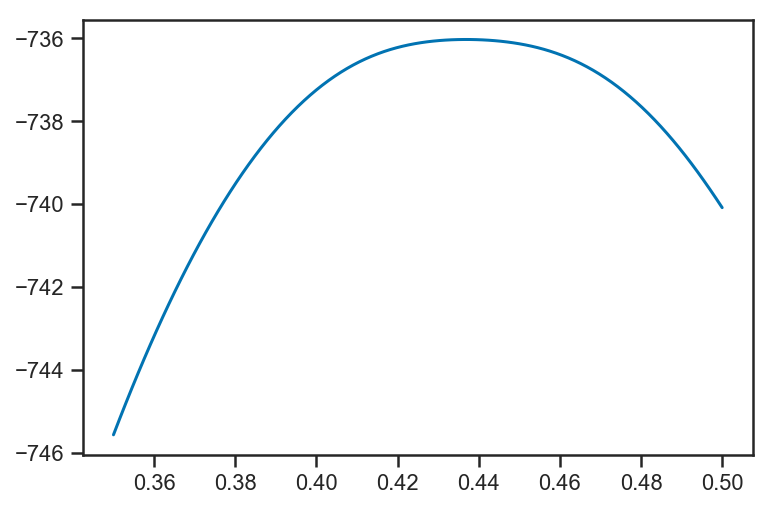

In [193]:
plot(xs, ys)

/Users/wfarr/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


ValueError: cannot convert float NaN to integer

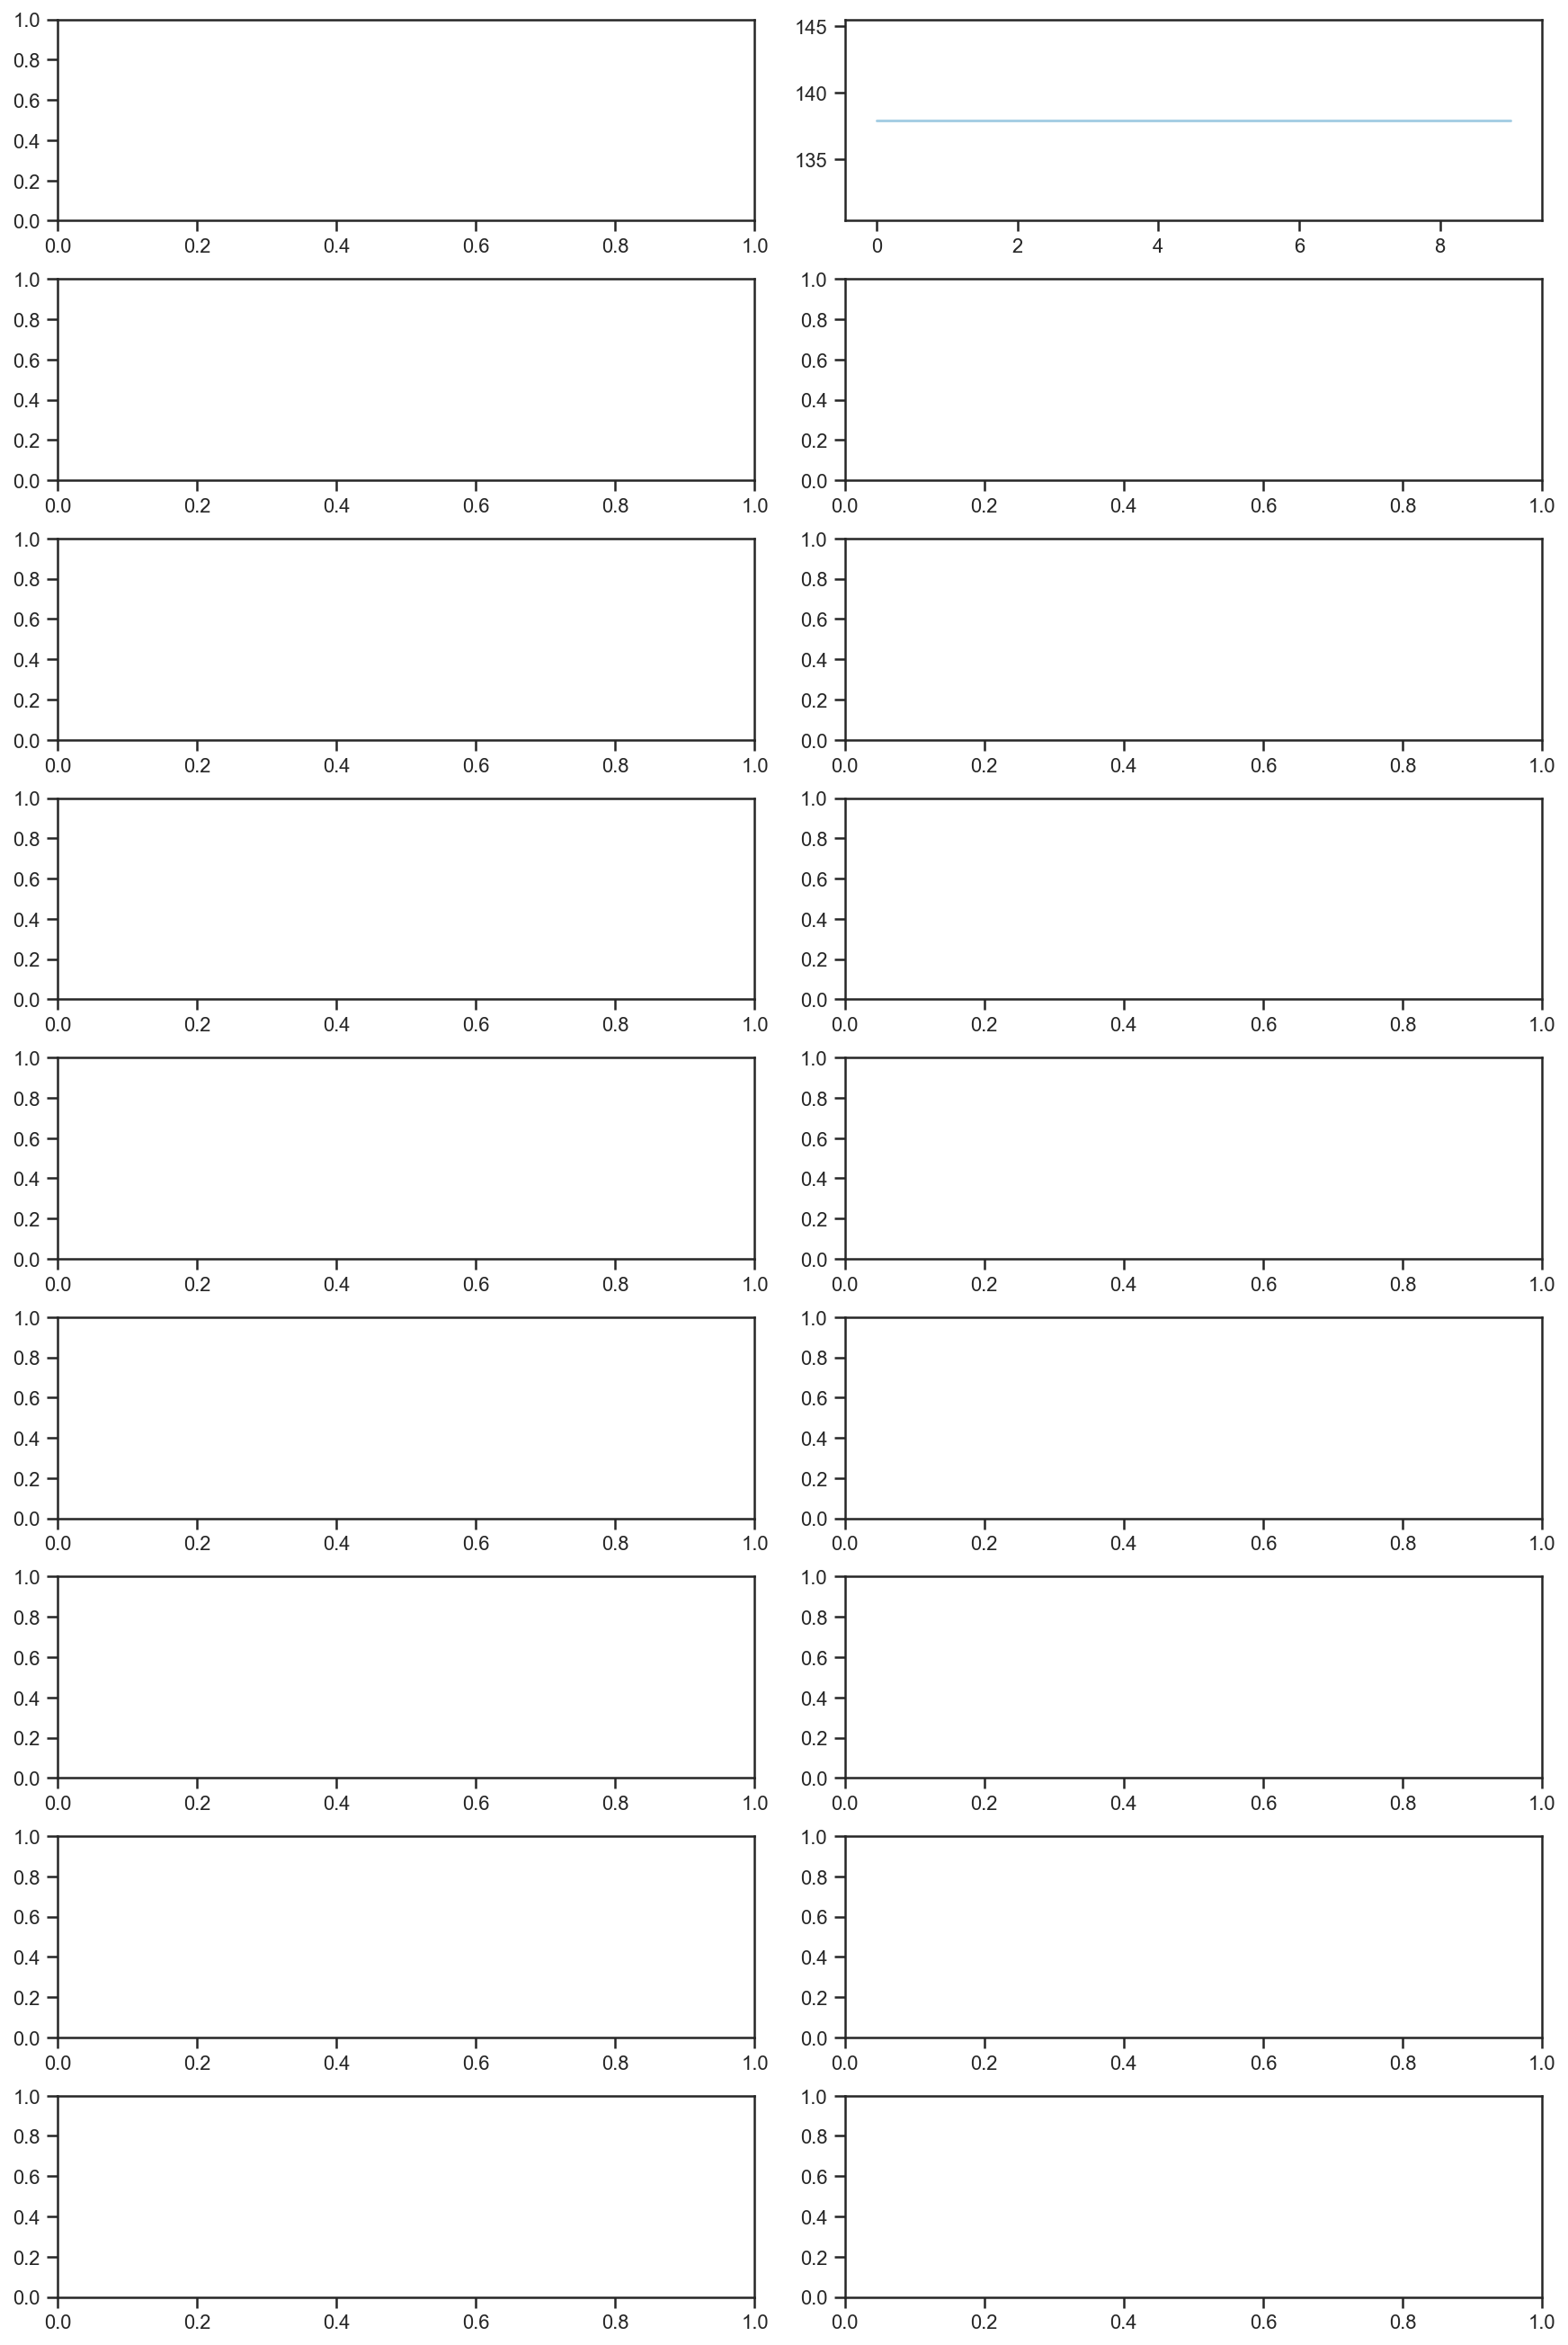

In [147]:
az.plot_trace(fit, var_names=['H0', 'Om', 'w', 'MMin', 'MMax', 'alpha', 'beta', 'gamma', 'neff_det'])

In [27]:
model.optimizing(data=data)

RuntimeError: Something went wrong after call_sampler.